In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime

from matplotlib import rcParams
import matplotlib as mpl

#svg.fonttype: path

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

#rcParams['axes.prop_cycle'] = cycler('color', [blue, gray, red, dark_gray, green, purple])

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (15, 9),
       dpi= 200,
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

## Strategy
1. identify adopted users
2. add col for time between account creation and initial login
3. add col for mean time between logins
4. add col - org size categorical
5. add col - invited by user group size
6. drop unneeded cols
7. transform categoricals

In [2]:
users = pd.read_csv('data/takehome_users.csv',  encoding = 'latin-1', parse_dates = ['creation_time'])
users.invited_by_user_id.isnull().sum()

users.invited_by_user_id = users.invited_by_user_id.fillna(0)
users.invited_by_user_id = users.invited_by_user_id.astype(int)
users.head()
users.info()

users.org_id.isnull().sum()

5583

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 937.6+ KB


0

In [3]:
engage = pd.read_csv('data/takehome_user_engagement.csv', parse_dates = ['time_stamp'])
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
# describe users DF
registered_users_ct = len(users)
mail_ct = users.opted_in_to_mailing_list.sum()
market_ct = users.enabled_for_marketing_drip.sum()

print("All users: {}".format(registered_users_ct))
print('Opted in to mailing list: {} - {:.2f}%'.format(mail_ct, mail_ct/registered_users_ct * 100))
print('Enabled for marketing drip: {} - {:.2f}%'.format(market_ct, market_ct/registered_users_ct * 100))

All users: 12000
Opted in to mailing list: 2994 - 24.95%
Enabled for marketing drip: 1792 - 14.93%


In [5]:
# describe engage df
logged_in_users_ct = engage.user_id.nunique()

print('There were {} logins from {} unique users'.format(len(engage), logged_in_users_ct))
print('{} registered users have never logged in'.format(registered_users_ct - logged_in_users_ct))
engage.head()
engage.info()

There were 207917 logins from 8823 unique users
3177 registered users have never logged in


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [6]:
# visited is always = 1, so drop the column
engage = engage.drop('visited', axis = 1)

## 1. identify adopted users

In [7]:
def get_rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

engage['visits_7_days'] = engage.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D')

engage.head(30)

,time_stamp,user_id,visits_7_days
0,2014-04-22 03:53:30,1,1.0
1,2013-11-15 03:45:04,2,1.0
2,2013-11-29 03:45:04,2,1.0
3,2013-12-09 03:45:04,2,1.0
4,2013-12-25 03:45:04,2,1.0
5,2013-12-31 03:45:04,2,2.0
6,2014-01-08 03:45:04,2,1.0
7,2014-02-03 03:45:04,2,1.0
8,2014-02-08 03:45:04,2,2.0
9,2014-02-09 03:45:04,2,3.0


In [8]:
adopted = engage[engage.visits_7_days >= 3]
len(adopted)

adopted = adopted.drop_duplicates('user_id', keep = 'first')
adopted_ids = adopted.user_id.tolist()
type(adopted_ids)
len(adopted_ids)


160522

list

1602

In [9]:
users['adopted'] = users.object_id.isin(adopted_ids)

users.adopted.sum()
users.head(20)

1602

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,False
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241,False
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0,False
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,0,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,0,False
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143,True


## 2. add col for time between account creation and initial login

In [10]:
# get initial login datetime from engage DF
grp = engage.groupby('user_id', as_index = False).agg({'time_stamp' : np.min})
grp.head(20)
grp.info()

,user_id,time_stamp
0,1,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52
3,4,2013-05-22 08:09:28
4,5,2013-01-22 10:14:20
5,6,2013-12-19 03:37:06
6,7,2012-12-20 13:24:32
7,10,2013-01-16 22:08:03
8,11,2013-12-27 03:55:54
9,13,2014-03-30 16:19:38


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 2 columns):
user_id       8823 non-null int64
time_stamp    8823 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 206.8 KB


In [11]:
# merge initial login column into users DF

grp.columns = ['user_id', 'initial_login']

users = users.merge(grp, how = 'left', left_on = 'object_id', right_on = 'user_id')
users.head()
users.info()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,user_id,initial_login
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,False,1.0,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,True,2.0,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,False,3.0,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,False,4.0,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,False,5.0,2013-01-22 10:14:20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
adopted                       12000 non-null bool
user_id                       8823 non-null float64
initial_login                 8823 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(2), int64(5), object(3)
memory usage: 1.2+ MB


In [12]:
users['creation_login_gap'] = (users.initial_login - users.creation_time).dt.days

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,user_id,initial_login,creation_login_gap
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,False,1.0,2014-04-22 03:53:30,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,True,2.0,2013-11-15 03:45:04,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,False,3.0,2013-03-19 23:14:52,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,False,4.0,2013-05-22 08:09:28,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,False,5.0,2013-01-22 10:14:20,5.0


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 14 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
adopted                       12000 non-null bool
user_id                       8823 non-null float64
initial_login                 8823 non-null datetime64[ns]
creation_login_gap            8823 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(3), int64(5), object(3)
memory usage: 1.3+ MB


## 3. add col for mean time between logins

In [14]:
gap = engage.groupby('user_id').time_stamp.apply(lambda x: x - x.shift()).dt.days
gaps = pd.DataFrame(gap)
gaps.columns = ['mean_gap_length']
gaps.head()
gaps.info()

,mean_gap_length
0,NaN
1,NaN
2,14.0
3,10.0
4,16.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 1 columns):
mean_gap_length    199094 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [15]:
engage = engage.merge(gaps, left_index = True, right_index = True)
engage.head()

,time_stamp,user_id,visits_7_days,mean_gap_length
0,2014-04-22 03:53:30,1,1.0,NaN
1,2013-11-15 03:45:04,2,1.0,NaN
2,2013-11-29 03:45:04,2,1.0,14.0
3,2013-12-09 03:45:04,2,1.0,10.0
4,2013-12-25 03:45:04,2,1.0,16.0


In [16]:
gap_mean = engage.groupby('user_id').agg({'mean_gap_length' : np.mean})
gap_mean.head()

,mean_gap_length
user_id,
1,NaN
2,10.461538
3,NaN
4,NaN
5,NaN


In [17]:
# merge mean login gap column into users DF

users = users.merge(gap_mean, how = 'left', left_on = 'object_id', right_on = 'user_id')
users.head()
users.info()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,user_id,initial_login,creation_login_gap,mean_gap_length
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,False,1.0,2014-04-22 03:53:30,0.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,True,2.0,2013-11-15 03:45:04,0.0,10.461538
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,False,3.0,2013-03-19 23:14:52,0.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,False,4.0,2013-05-22 08:09:28,1.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,False,5.0,2013-01-22 10:14:20,5.0,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 15 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
adopted                       12000 non-null bool
user_id                       8823 non-null float64
initial_login                 8823 non-null datetime64[ns]
creation_login_gap            8823 non-null float64
mean_gap_length               2588 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(4), int64(5), object(3)
memory usage: 1.4+ MB


## 4. add col org id size

In [18]:
# orgs = users[(users.org_id > 10) & (users.org_id < 20)]
orgs = users.org_id.value_counts()
orgs.head(10)
orgs.tail()

0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
Name: org_id, dtype: int64

396    9
400    8
397    8
386    7
416    2
Name: org_id, dtype: int64

In [19]:
one = users[users.org_id == 396]
one.shape

(9, 15)

In [20]:
o = pd.DataFrame(orgs).reset_index()
o.columns = ['org_id', 'user_count']
o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 2 columns):
org_id        417 non-null int64
user_count    417 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


In [21]:
def org_size(ct):
    rtn = 'XS'
    if ct > 200:
        rtn = 'XL'
    elif ct > 149:
        rtn = 'L'
    elif ct > 99:
        rtn = 'M'
    elif ct > 49:
        rtn = 'S'

    return rtn

o['org_size'] = o.user_count.apply(org_size)

o.head()

,org_id,user_count,org_size
0,0,319,XL
1,1,233,XL
2,2,201,XL
3,3,168,L
4,4,159,L


In [22]:
org_size_dict = dict(zip(o.org_id, o.org_size))
len(org_size_dict)
org_size_dict[0] = np.nan

417

In [23]:
users['org_size'] = users.org_id.map(org_size_dict)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,user_id,initial_login,creation_login_gap,mean_gap_length,org_size
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,False,1.0,2014-04-22 03:53:30,0.0,NaN,S
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,True,2.0,2013-11-15 03:45:04,0.0,10.461538,XL
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,False,3.0,2013-03-19 23:14:52,0.0,NaN,XS
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,False,4.0,2013-05-22 08:09:28,1.0,NaN,XL
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,False,5.0,2013-01-22 10:14:20,5.0,NaN,XS


## 5. add col for bool - invited by user

In [24]:
invites = users.invited_by_user_id.value_counts()
invites.head()

0        5583
10741      13
2527       12
11770      11
2308       11
Name: invited_by_user_id, dtype: int64

In [25]:
i = pd.DataFrame(invites).reset_index()
i.columns = ['inviter_id', 'user_count']
i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 0 to 2564
Data columns (total 2 columns):
inviter_id    2565 non-null int64
user_count    2565 non-null int64
dtypes: int64(2)
memory usage: 40.2 KB


In [26]:
def group_size(ct):
    rtn = 'XS'
    if ct > 11:
        rtn = 'XL'
    elif ct > 8:
        rtn = 'L'
    elif ct > 5:
        rtn = 'M'
    elif ct > 3:
        rtn = 'S'
    elif ct == 0:
        rtn = np.nan
    return rtn

i['group_size'] = i.user_count.apply(group_size)

i.head()

,inviter_id,user_count,group_size
0,0,5583,XL
1,10741,13,XL
2,2527,12,XL
3,11770,11,L
4,2308,11,L


In [27]:
group_size_dict = dict(zip(i.inviter_id, i.group_size))
len(group_size_dict)
group_size_dict[0] = np.nan

2565

In [28]:
users['group_size'] = users.invited_by_user_id.map(group_size_dict)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,user_id,initial_login,creation_login_gap,mean_gap_length,org_size,group_size
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,False,1.0,2014-04-22 03:53:30,0.0,NaN,S,XS
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,True,2.0,2013-11-15 03:45:04,0.0,10.461538,XL,XS
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,False,3.0,2013-03-19 23:14:52,0.0,NaN,XS,L
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,False,4.0,2013-05-22 08:09:28,1.0,NaN,XL,M
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,False,5.0,2013-01-22 10:14:20,5.0,NaN,XS,S


## 6. drop unneeded cols

In [29]:
users = users.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
                    'invited_by_user_id', 'org_id', 'user_id', 'initial_login'], axis = 1)

In [30]:
y = users.adopted
users = users.drop('adopted', axis = 1)

users.head()
users.info()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_login_gap,mean_gap_length,org_size,group_size
0,GUEST_INVITE,1,0,0.0,NaN,S,XS
1,ORG_INVITE,0,0,0.0,10.461538,XL,XS
2,ORG_INVITE,0,0,0.0,NaN,XS,L
3,GUEST_INVITE,0,0,1.0,NaN,XL,M
4,GUEST_INVITE,0,0,5.0,NaN,XS,S


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 7 columns):
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
creation_login_gap            8823 non-null float64
mean_gap_length               2588 non-null float64
org_size                      11681 non-null object
group_size                    6417 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 750.0+ KB


## 7. transform categoricals

In [31]:
users = pd.get_dummies(users, columns = ['creation_source', 'org_size', 'group_size'])

In [32]:
users = users.join(y)
users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_login_gap,mean_gap_length,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_size_L,org_size_M,org_size_S,org_size_XL,org_size_XS,group_size_L,group_size_M,group_size_S,group_size_XL,group_size_XS,adopted
0,1,0,0.0,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,False
1,0,0,0.0,10.461538,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,True
2,0,0,0.0,NaN,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,False
3,0,0,1.0,NaN,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,False
4,0,0,5.0,NaN,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,False


In [33]:
users.mean_gap_length = users.mean_gap_length.fillna(100)

users.creation_login_gap = users.creation_login_gap.fillna(100)

users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 20 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
creation_login_gap                    12000 non-null float64
mean_gap_length                       12000 non-null float64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
org_size_L                            12000 non-null uint8
org_size_M                            12000 non-null uint8
org_size_S                            12000 non-null uint8
org_size_XL                           12000 non-null uint8
org_size_XS                           12000 non-null uint8
group_size_L                          12000 non-null uint8
gr

In [34]:
users.to_csv('data/modeling.csv')

## Modeling

In [35]:
# sklearn imports
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

test_file_url = '~/Documents/Data Science/Data Projects/Take Home Challenge/relax_challenge/data/modeling.csv'
# set random_state SEED variable
SEED = 42

In [36]:
# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# training set breakdown
train_success = y_train.sum()
train_total = len(y_train)
train_percent = train_success / train_total
print('Training Set\nSuccesses:\t{}\nTotal:\t\t{}\nPercent:\t{:.3f}\n'.format(train_success, train_total, train_percent))

# test set breakdown
test_success = y_test.sum()
test_total = len(y_test)
test_percent = test_success / test_total
print('Test Set\nSuccesses:\t{}\nTotal:\t\t{}\nPercent:\t{:.3f}\n\n'.format(test_success, test_total, test_percent))

Training Set
Successes:	1116
Total:		8400
Percent:	0.133

Test Set
Successes:	486
Total:		3600
Percent:	0.135




## Dummy Classifier

Dummy Classifier accuracy: 0.7644


             precision    recall  f1-score   support

      False       0.86      0.87      0.86      3114
       True       0.12      0.12      0.12       486

avg / total       0.76      0.76      0.76      3600



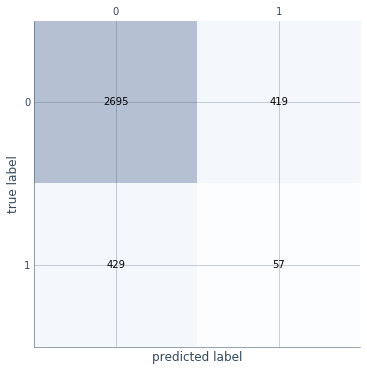

In [37]:
# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate and fit a dummy classifier
dummy = DummyClassifier(random_state = SEED)
dummy.fit(X_train, y_train)

# make predictions
y_pred = dummy.predict(X_test)

# SCORING
# accuracy
dummy_accuracy = dummy.score(X_test, y_test)
print('Dummy Classifier accuracy: {:.4f}\n\n'.format(dummy_accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

## SMOTE

In [38]:
#imports
from imblearn.over_sampling import SMOTE

# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# SMOTE IT!
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

# training set breakdown
train_success = y_train_sm.sum()
train_total = len(y_train_sm)
train_percent = train_success / train_total
print('Training Set\nSuccesses:\t{}\nTotal:\t\t{}\nPercent:\t{:.3f}\n'.format(train_success, train_total, train_percent))

# test set breakdown
test_success = y_test.sum()
test_total = len(y_test)
test_percent = test_success / test_total
print('Test Set\nSuccesses:\t{}\nTotal:\t\t{}\nPercent:\t{:.3f}\n\n'.format(test_success, test_total, test_percent))

Training Set
Successes:	7284
Total:		14568
Percent:	0.500

Test Set
Successes:	486
Total:		3600
Percent:	0.135




## Dummy Classifier

Dummy Classifier accuracy: 0.5122


             precision    recall  f1-score   support

      False       0.87      0.51      0.64      3114
       True       0.14      0.53      0.23       486

avg / total       0.77      0.51      0.59      3600



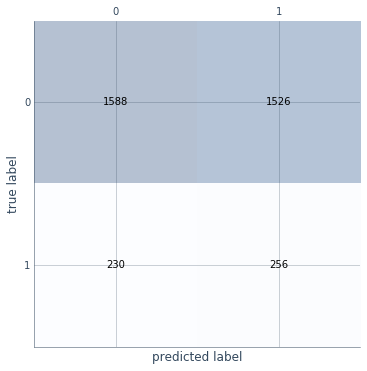

In [39]:
# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# SMOTE IT!
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

# instantiate and fit a dummy classifier
dummy = DummyClassifier(random_state = SEED)
dummy.fit(X_train_sm, y_train_sm)

# make predictions
y_pred = dummy.predict(X_test)

# SCORING
# accuracy
dummy_accuracy = dummy.score(X_test, y_test)
print('Dummy Classifier accuracy: {:.4f}\n\n'.format(dummy_accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

## Logistic Regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Logistic Regression Accuracy:	0.9547

             precision    recall  f1-score   support

      False       1.00      0.95      0.97      3114
       True       0.76      0.98      0.85       486

avg / total       0.96      0.95      0.96      3600



Text(0,0,'2960')

Text(1,0,'154')

Text(0,1,'9')

Text(1,1,'477')

Text(0.5,0,'predicted label')

Text(0,0.5,'true label')

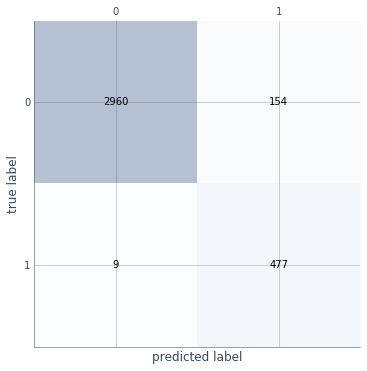

In [40]:
# imports
from sklearn.linear_model import LogisticRegression

# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# SMOTE IT!
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

# instantiate & fit model
model = LogisticRegression(random_state = SEED)
model.fit(X_train_sm, y_train_sm)

# make predictions on test features
y_pred = model.predict(X_test)

# score predictions
accuracy = model.score(X_test, y_test)
print('Logistic Regression Accuracy:\t{:.4f}\n'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

# take a look at feature importance
# imp = pd.Series(model.feature_importances_, index=X.columns)
# imp = imp.sort_values(ascending=False)
# print(imp);

## LinearSVC

Accuracy: 0.9486
             precision    recall  f1-score   support

      False       1.00      0.94      0.97      3114
       True       0.73      0.99      0.84       486

avg / total       0.96      0.95      0.95      3600



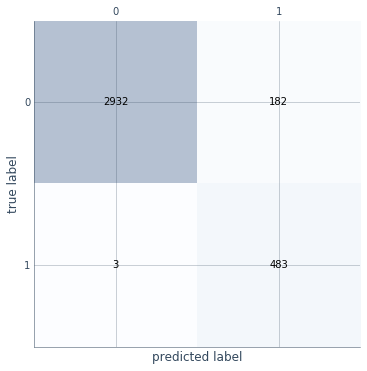

In [41]:
#imports
from sklearn.svm import LinearSVC

# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# SMOTE IT!
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

# instantiate and fit the learning algorithm
model = LinearSVC(random_state=SEED)
model.fit(X_train_sm, y_train_sm)

# make predictions on test features
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

## SVC

Accuracy: 0.9486
             precision    recall  f1-score   support

      False       1.00      0.94      0.97      3114
       True       0.73      0.99      0.84       486

avg / total       0.96      0.95      0.95      3600



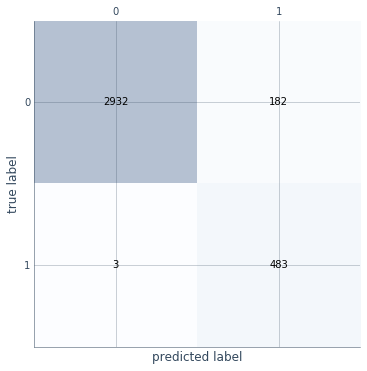

In [42]:
from sklearn.svm import SVC

# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# SMOTE IT!
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

# instantiate the learning algorithm
model = SVC(random_state = SEED)

# create a params dict
model.fit(X_train_sm, y_train_sm)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

## Random Forest

Accuracy: 0.9628
             precision    recall  f1-score   support

      False       0.98      0.98      0.98      3114
       True       0.87      0.85      0.86       486

avg / total       0.96      0.96      0.96      3600



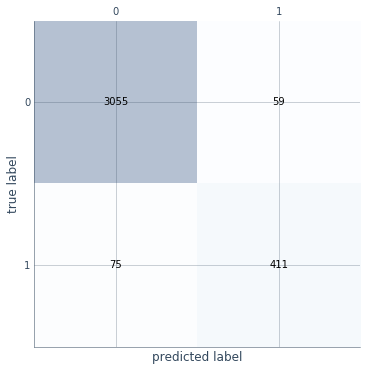

In [43]:
from sklearn.ensemble import RandomForestClassifier

# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# SMOTE IT!
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

# instantiate & fit
model = RandomForestClassifier(random_state = SEED)
model.fit(X_train_sm, y_train_sm)

# make predictions on the test set
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

### Random Forest - Tuning

Best max_depth: 10
Best min_samples_leaf: 0.01
Best n_estimators: 50
Accuracy: 0.9602777777777778
             precision    recall  f1-score   support

      False       1.00      0.96      0.98      3114
       True       0.79      0.97      0.87       486

avg / total       0.97      0.96      0.96      3600

mean_gap_length                       0.796703
creation_login_gap                    0.137101
org_size_XS                           0.028182
creation_source_PERSONAL_PROJECTS     0.008612
org_size_S                            0.007128
opted_in_to_mailing_list              0.006436
enabled_for_marketing_drip            0.003102
org_size_XL                           0.002895
org_size_M                            0.002877
group_size_S                          0.001662
group_size_XS                         0.001148
org_size_L                            0.001022
creation_source_ORG_INVITE            0.000852
creation_source_GUEST_INVITE          0.000712
creation_source_SIGNUP       

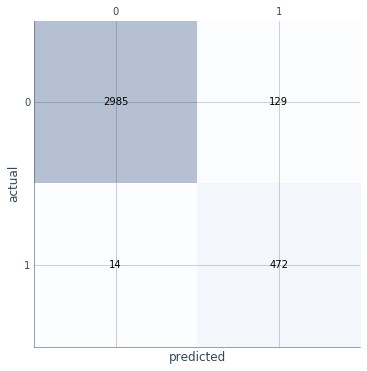

In [46]:
# import data and split into features matrix and target vector
df = pd.read_csv(test_file_url, index_col = 0)

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# SMOTE IT!
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

# instantiate the learning algorithm
model = RandomForestClassifier(random_state = SEED)

# create a params dict
depth = [2, 3, 4, 5, 6, 10, 15, 20]
min_samples = [.01, .025, .05, .075, .1, .2]
est = [5, 10, 50, 100, 500]
hyperparameters = dict(max_depth = depth, 
                       min_samples_leaf = min_samples,
                       n_estimators = est)

# instantiate grid search
gridsearch = GridSearchCV(model, hyperparameters, cv = 5, verbose = 0)

# fit grid search
best_model = gridsearch.fit(X_train_sm, y_train_sm)

# print the best hyperparameters
best_depth = best_model.best_estimator_.get_params()['max_depth']
best_min_samples = best_model.best_estimator_.get_params()['min_samples_leaf']
best_est = best_model.best_estimator_.get_params()['n_estimators']
print('Best max_depth: {}'.format(best_depth))
print('Best min_samples_leaf: {}'.format(best_min_samples))
print('Best n_estimators: {}'.format(best_est))


# BUILD MODEL WITH BEST HYPERPARAMETERS

# instantiate a RandomForestClassifier
tuned_model = RandomForestClassifier(max_depth = best_depth,
                                     min_samples_leaf = best_min_samples,
                                     n_estimators = best_est,
                                     random_state = SEED,
                                     n_jobs = -1)

# train the model
tuned_model.fit(X_train_sm, y_train_sm)

# make predictions
tuned_model_y_pred = tuned_model.predict(X_test)

# SCORING
# accuracy
acc = accuracy_score(y_test, tuned_model_y_pred)
print('Accuracy: {}'.format(acc))

# classification report
print(classification_report(y_test, tuned_model_y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = tuned_model_y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted')
plt.ylabel('actual')

# take a look at feature importance
imp = pd.Series(tuned_model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp);